In [97]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders
import warnings
warnings.filterwarnings("ignore")
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn import preprocessing

In [98]:
df = pd.read_excel("data.xlsx",index_col='Month', parse_dates=True)

In [99]:
df

,Sales,Budget
Month,,
2015-01-01,14840.0,13740.0
2015-02-01,14820.0,16466.0
2015-03-01,17920.0,18474.0
2015-04-01,19020.0,17449.0
2015-05-01,20600.0,22150.0
...,...,...
2020-08-01,NaN,17226.0
2020-09-01,NaN,19822.0
2020-10-01,NaN,22506.0


In [100]:
df_sales = df[df.index<'2020-01-01'][['Sales']]

In [101]:
from sklearn.preprocessing import MinMaxScaler

,ts
Month,
2015-01-01,1.017822
2015-02-01,1.017426
2015-03-01,1.078812
2015-04-01,1.100594
2015-05-01,1.131881


(60, 1)

,ts
count,60.000000
mean,1.262363
std,0.220233
min,1.000000
25%,1.123960
50%,1.205347
75%,1.331089
85%,1.362515
95%,1.733941
99%,1.926162


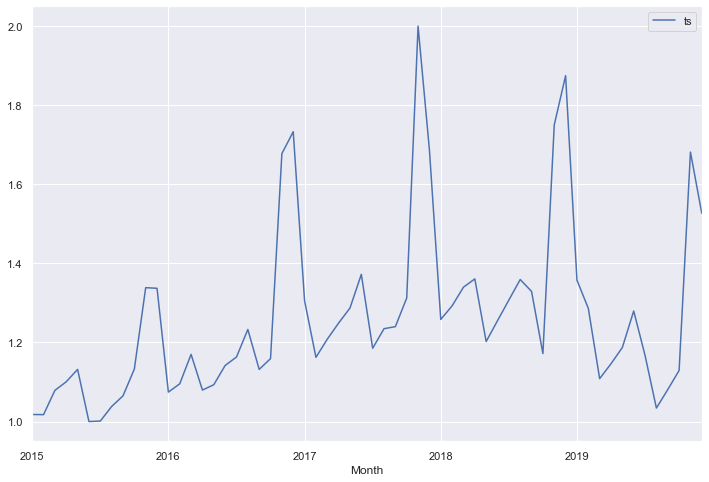

In [102]:
scaler = MinMaxScaler()
scaler.fit(df_sales) #Finds the max value in training data

scaled_df_sales=scaler.transform(df_sales)

df_sales['scaled']=scaled_df_sales[:]+1
df_sales=df_sales.drop(columns=['Sales'])

# Rename columns
df_sales = df_sales.rename(columns = {'scaled': 'ts'})

# look at data
display(df_sales.head())

# look a shape of data
display(df_sales.shape)

# display descriptive statistics
display(df_sales.describe(percentiles=[0.25,0.5,0.75,0.85,0.95,0.99]))

df_sales.plot(figsize=(12,8));

In [132]:
scaler.inverse_transform([[.13686448,.167066474,.12904377,.124311327,.615799192,.573559669]])

array([[20851.65624  , 22376.856937 , 20456.710385 , 20217.7220135,
        45037.859196 , 42904.7632845]])

In [137]:
scaler.inverse_transform([[.352505,.297082,.373824]])

array([[31741.5025, 28942.641 , 32818.112 ]])

In [141]:
scaler.inverse_transform([[.144029307
,.187898052
,.166193135
,.177002682
,.681682349
,.65032412
]]) 

array([[21213.4800035, 23428.851626 , 22332.7533175, 22878.635441 ,
        48364.9586245, 46781.36806  ]])

In [140]:
scaler.inverse_transform([[.240395241,.201825135,.201754815]])

array([[26079.9596705, 24132.1693175, 24128.6181575]])

In [ ]:
0.16
p
d
q

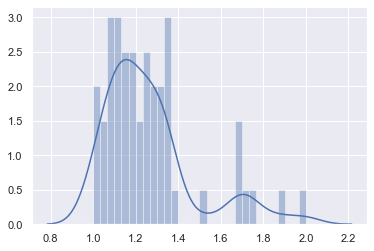

In [103]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

sns.set(color_codes=True)

sns.distplot(df_sales,bins=30);

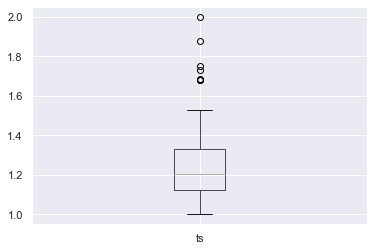

In [104]:
df_sales.boxplot()

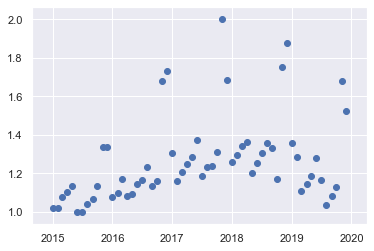

In [105]:
plt.scatter(df_sales.index,df_sales.ts)

Text(0.5, 0.98, 'Additive Decompose')

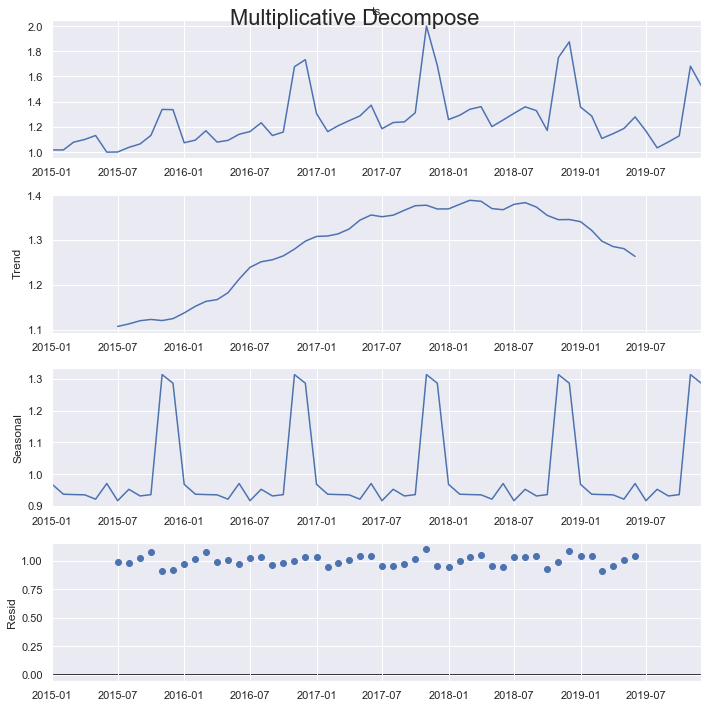

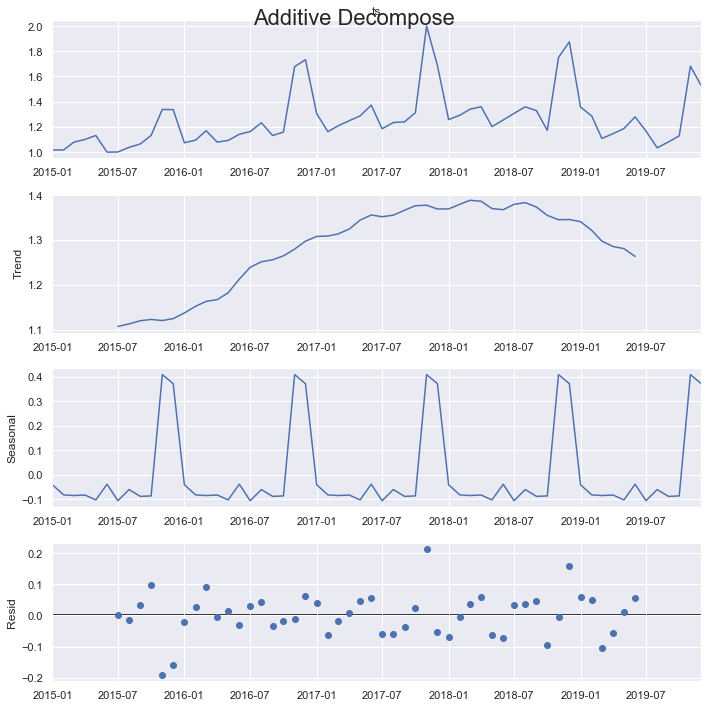

In [106]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(df_sales['ts'], model='multiplicative', freq=12)

# Additive Decomposition
result_add = seasonal_decompose(df_sales['ts'], model='additive', freq=12)

# Plot

plt.rcParams.update({'figure.figsize': (10,10)})

result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)


In [107]:
df_sales['trend'] = result_add.trend
df_sales['seasonal'] = result_add.seasonal
df_sales['resid'] = result_add.resid

In [108]:
df_sales.to_csv("df_sales_break.csv")

### Check if our data is stationary or not

Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

If P-value < 0.05 => data is stationary

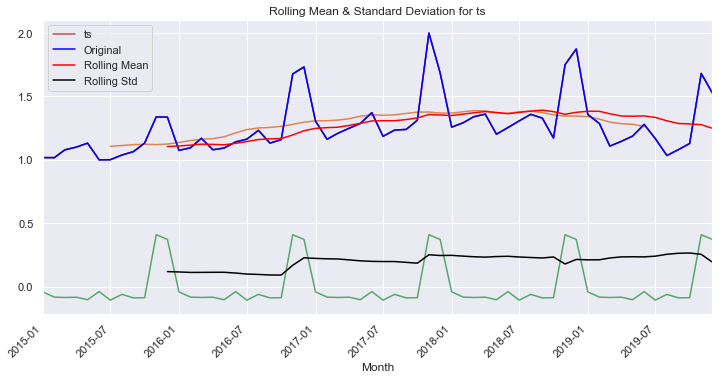

Results of Dickey-Fuller Test:
Test Statistic                 -1.598547
p-value                         0.484323
# Lags Used                    10.000000
Number of Observations Used    49.000000
Critical Value (1%)            -3.571472
Critical Value (5%)            -2.922629
Critical Value (10%)           -2.599336
dtype: float64


In [91]:

plt.plot(df_sales.index, df_sales.values);
ax = df_sales['ts'].plot(figsize=(12,6))
ax.autoscale(axis='x',tight=True)
from statsmodels.tsa.stattools import adfuller
def test_stationarity(df, ts):
    """
    Test stationarity using moving average statistics and Dickey-Fuller test
    Source: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
    """
    
    # Determing rolling statistics
    rolmean = df[ts].rolling(window = 12, center = False).mean()
    rolstd = df[ts].rolling(window = 12, center = False).std()
    
    # Plot rolling statistics:
    orig = plt.plot(df[ts], 
                    color = 'blue', 
                    label = 'Original')
    mean = plt.plot(rolmean, 
                    color = 'red', 
                    label = 'Rolling Mean')
    std = plt.plot(rolstd, 
                   color = 'black', 
                   label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation for %s' %(ts))
    plt.xticks(rotation = 45)
    plt.show(block = False)
    plt.close()
    
    # Perform Dickey-Fuller test:
    # Null Hypothesis (H_0): time series is not stationary
    # Alternate Hypothesis (H_1): time series is stationary
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(df[ts])
    dfoutput = pd.Series(dftest[0:4], 
                         index = ['Test Statistic',
                                  'p-value',
                                  '# Lags Used',
                                  'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
test_stationarity(df = df_sales, ts = 'ts')

Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

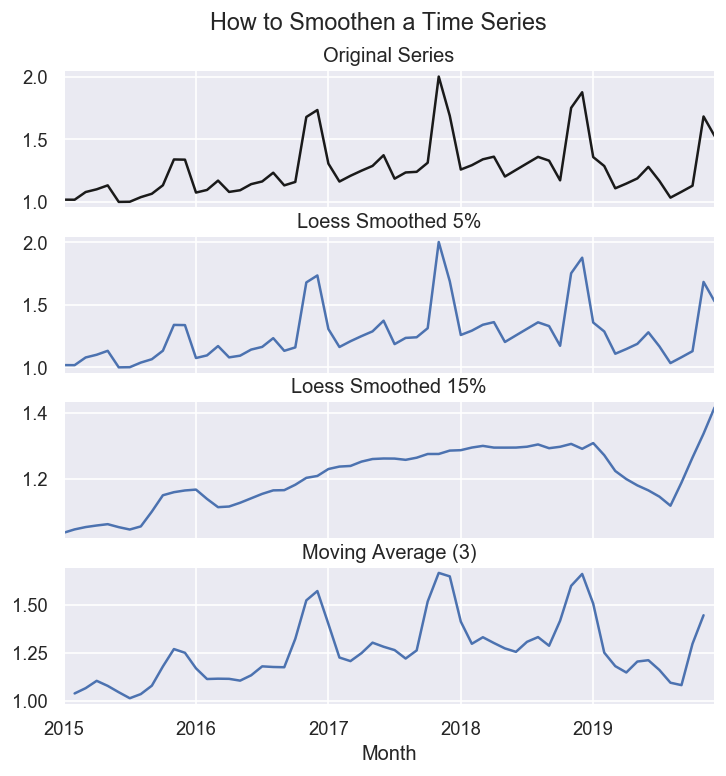

In [92]:
from statsmodels.nonparametric.smoothers_lowess import lowess
plt.rcParams.update({'xtick.bottom' : False, 'axes.titlepad':5})

# 1. Moving Average
df_ma = df_sales.ts.rolling(3, center=True, closed='both').mean()

# 2. Loess Smoothing (5% and 15%)
df_loess_5 = pd.DataFrame(lowess(df_sales.ts, np.arange(len(df_sales.ts)), frac=0.05)[:, 1], index=df_sales.index, columns=['ts'])
df_loess_15 = pd.DataFrame(lowess(df_sales.ts, np.arange(len(df_sales.ts)), frac=0.15)[:, 1], index=df_sales.index, columns=['ts'])

# Plot
fig, axes = plt.subplots(4,1, figsize=(7, 7), sharex=True, dpi=120)
df_sales['ts'].plot(ax=axes[0], color='k', title='Original Series')
df_loess_5['ts'].plot(ax=axes[1], title='Loess Smoothed 5%')
df_loess_15['ts'].plot(ax=axes[2], title='Loess Smoothed 15%')
df_ma.plot(ax=axes[3], title='Moving Average (3)')
fig.suptitle('How to Smoothen a Time Series', y=0.95, fontsize=14)
plt.show()

### Making data stationary using difference
The first step to build an ARIMA model is to make the time series stationary. Why? Because, term ‘Auto Regressive’ in ARIMA means it is a linear regression model that uses its own lags as predictors. Linear regression models, as you know, work best when the predictors are not correlated and are independent of each other.

In [93]:
def plot_transformed_data(df, ts, ts_transform):
  """
  Plot transformed and original time series data
  """
  # Plot time series data
  f, ax = plt.subplots(1,1)
  ax.plot(df[ts])
  ax.plot(df[ts_transform], color = 'red')

  # Add title
  ax.set_title('%s and %s time-series graph' %(ts, ts_transform))

  # Rotate x-labels
  ax.tick_params(axis = 'x', rotation = 45)

  # Add legend
  ax.legend([ts, ts_transform])
  
  plt.show()
  plt.close()
  
  return

,ts,trend,seasonal,ts_log,ts_diff,ts_log_moving_avg,ts_moving_avg,ts_log_diff,ts_moving_avg_diff,ts_log_moving_avg_diff,ts_log_ewma,ts_log_ewma_diff
Month,,,,,,,,,,,,
2015-12-01,1.337030,1.124653,0.372115,0.290451,-0.001584,0.094886,1.104917,-0.001184,0.232112,0.195565,0.290451,0.000000
2016-01-01,1.074455,1.137310,-0.041635,0.071814,-0.262574,0.099398,1.109637,-0.218637,-0.035182,-0.027584,0.177976,-0.106162
2016-02-01,1.095446,1.152178,-0.083025,0.091161,0.020990,0.105555,1.116139,0.019347,-0.020693,-0.014394,0.147351,-0.056190
2016-03-01,1.169901,1.163086,-0.085723,0.156919,0.074455,0.112310,1.123729,0.065758,0.046172,0.044609,0.149954,0.006965
2016-04-01,1.079604,1.166980,-0.083574,0.076594,-0.090297,0.110705,1.121980,-0.080325,-0.042376,-0.034111,0.133540,-0.056946


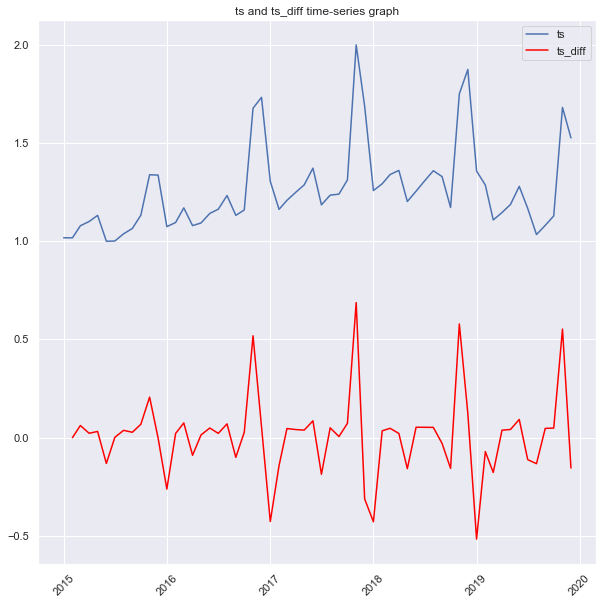

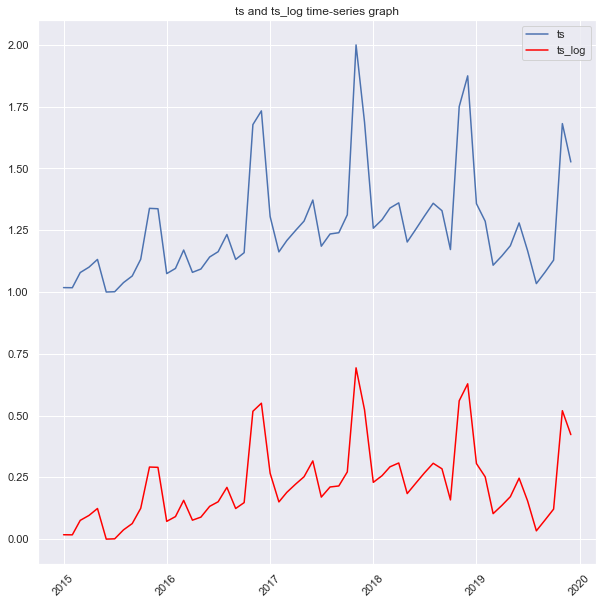

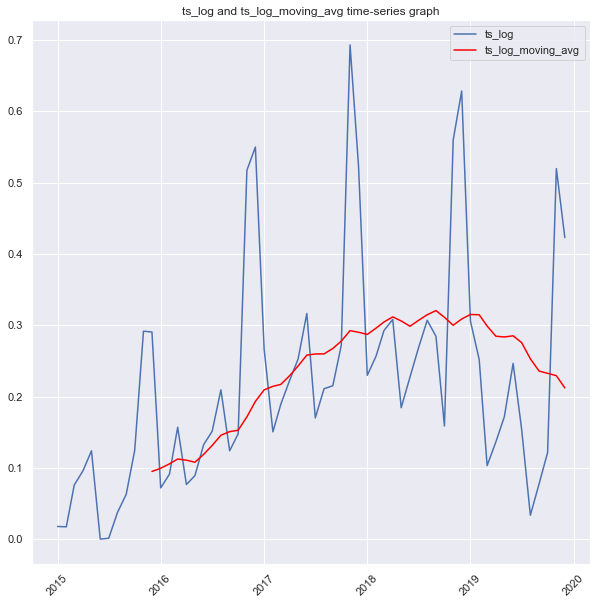

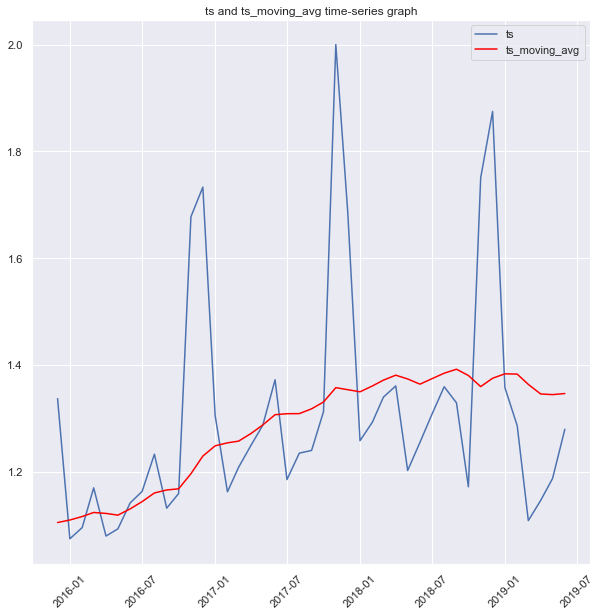

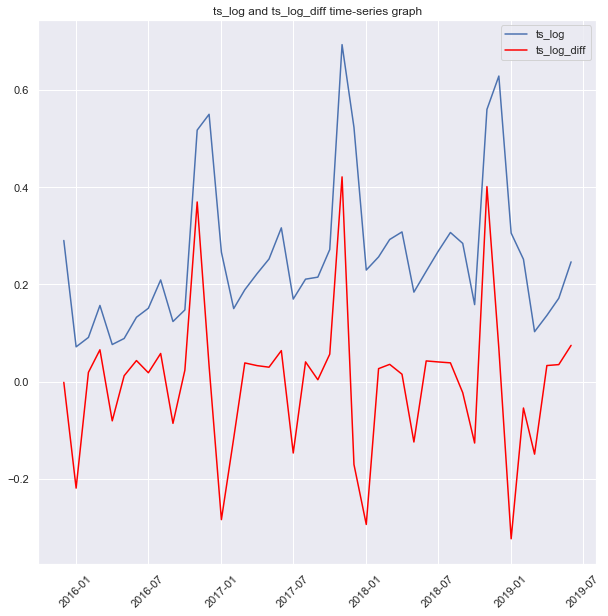

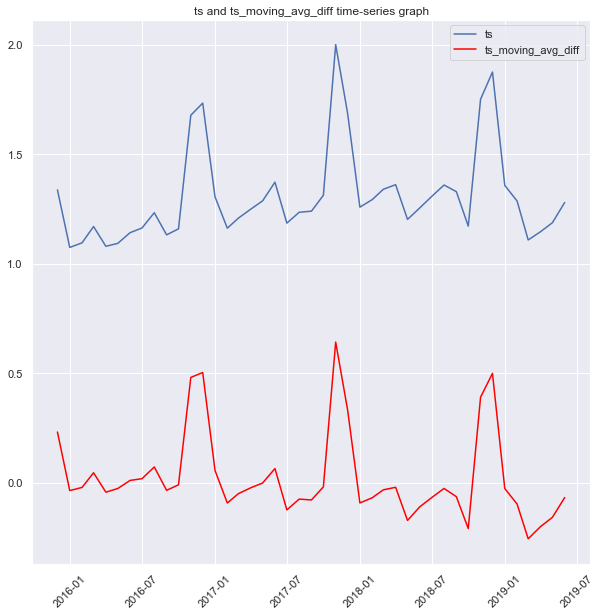

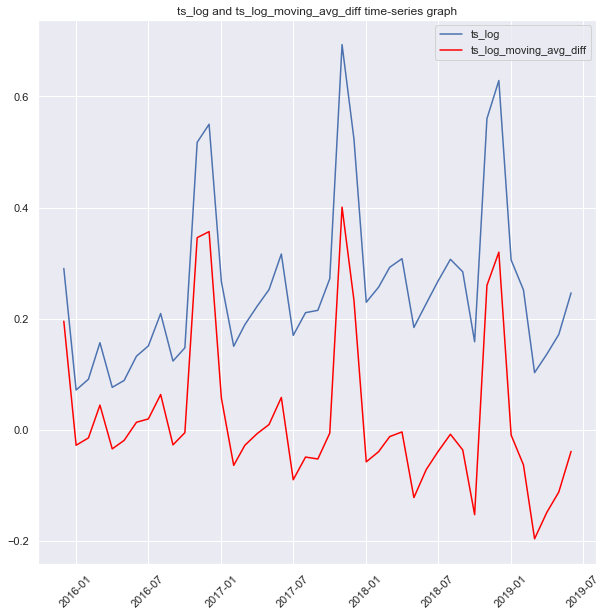

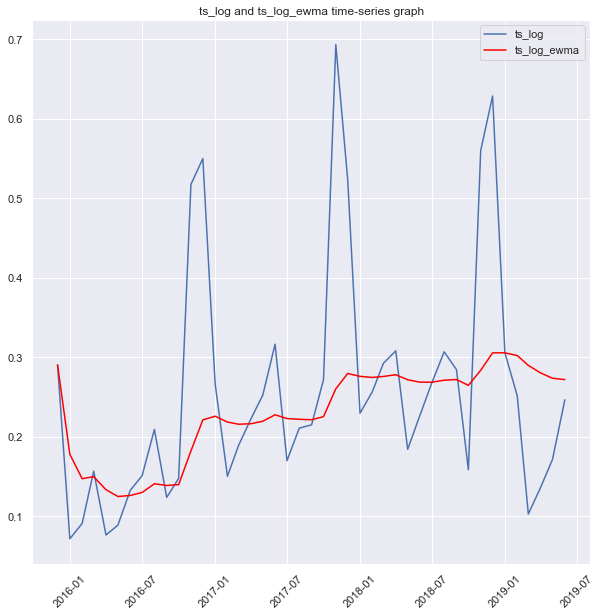

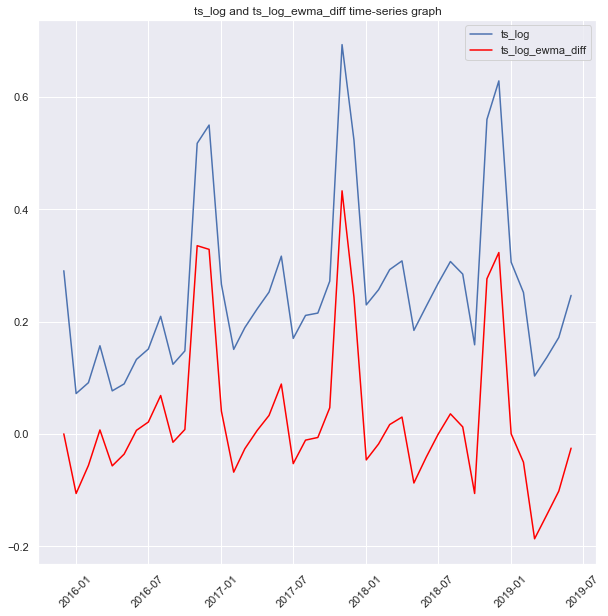

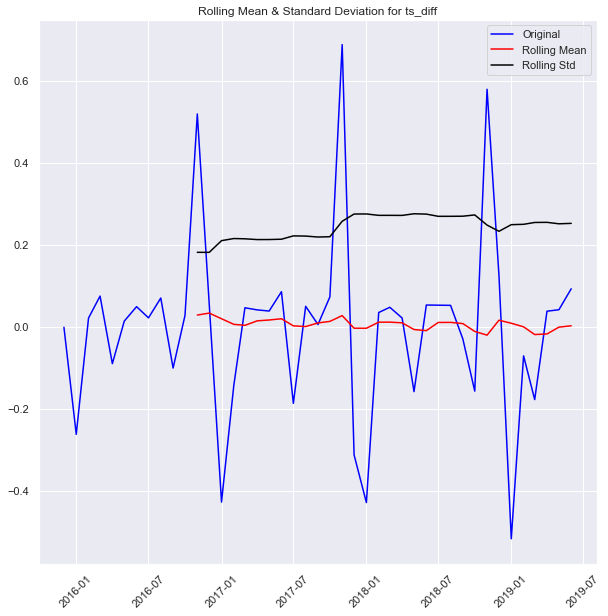

Results of Dickey-Fuller Test:
Test Statistic                 -4.847752
p-value                         0.000044
# Lags Used                    10.000000
Number of Observations Used    32.000000
Critical Value (1%)            -3.653520
Critical Value (5%)            -2.957219
Critical Value (10%)           -2.617588
dtype: float64


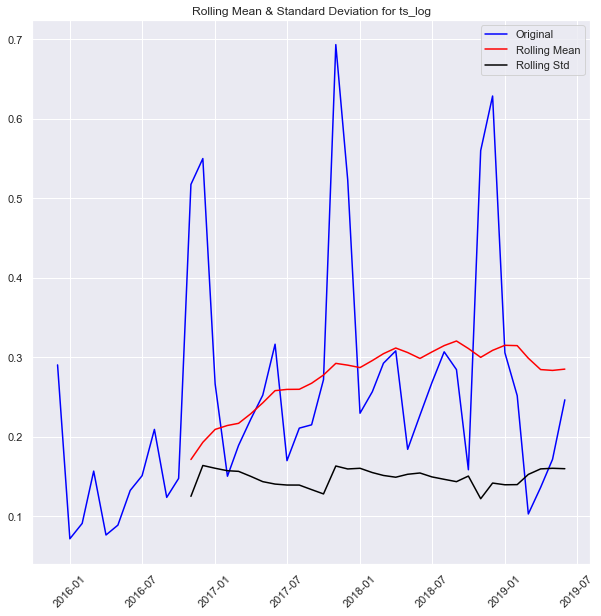

Results of Dickey-Fuller Test:
Test Statistic                 -3.442434
p-value                         0.009595
# Lags Used                    10.000000
Number of Observations Used    32.000000
Critical Value (1%)            -3.653520
Critical Value (5%)            -2.957219
Critical Value (10%)           -2.617588
dtype: float64


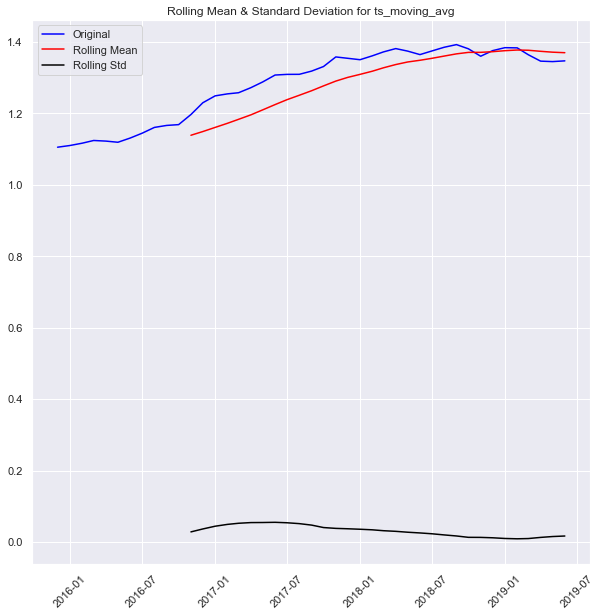

Results of Dickey-Fuller Test:
Test Statistic                 -3.968708
p-value                         0.001584
# Lags Used                     5.000000
Number of Observations Used    37.000000
Critical Value (1%)            -3.620918
Critical Value (5%)            -2.943539
Critical Value (10%)           -2.610400
dtype: float64


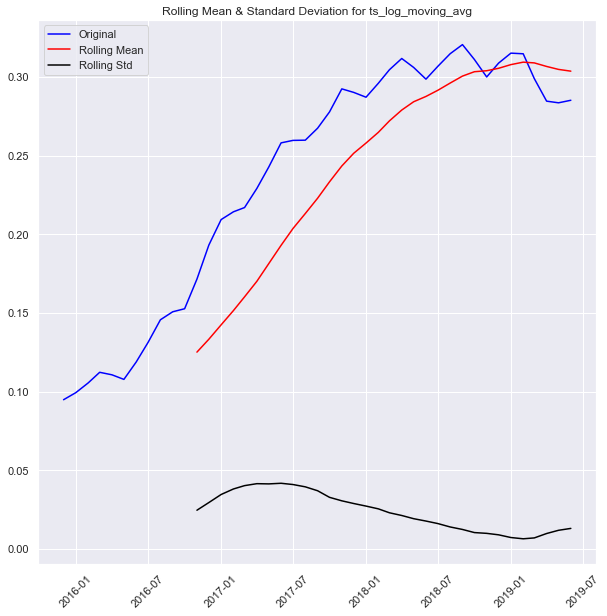

Results of Dickey-Fuller Test:
Test Statistic                 -2.867536
p-value                         0.049255
# Lags Used                     6.000000
Number of Observations Used    36.000000
Critical Value (1%)            -3.626652
Critical Value (5%)            -2.945951
Critical Value (10%)           -2.611671
dtype: float64


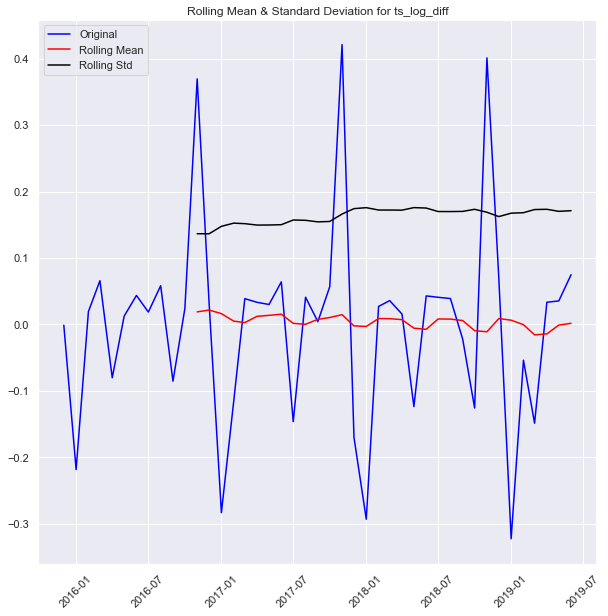

Results of Dickey-Fuller Test:
Test Statistic                -7.179182e+00
p-value                        2.677570e-10
# Lags Used                    9.000000e+00
Number of Observations Used    3.300000e+01
Critical Value (1%)           -3.646135e+00
Critical Value (5%)           -2.954127e+00
Critical Value (10%)          -2.615968e+00
dtype: float64


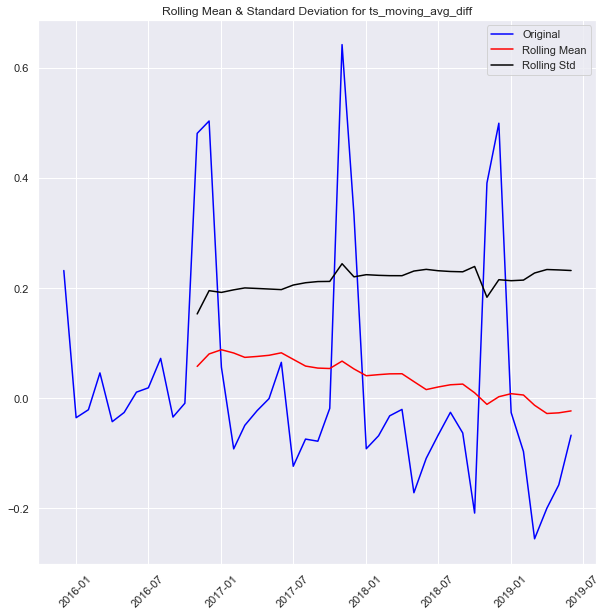

Results of Dickey-Fuller Test:
Test Statistic                 -0.960252
p-value                         0.767484
# Lags Used                    10.000000
Number of Observations Used    32.000000
Critical Value (1%)            -3.653520
Critical Value (5%)            -2.957219
Critical Value (10%)           -2.617588
dtype: float64


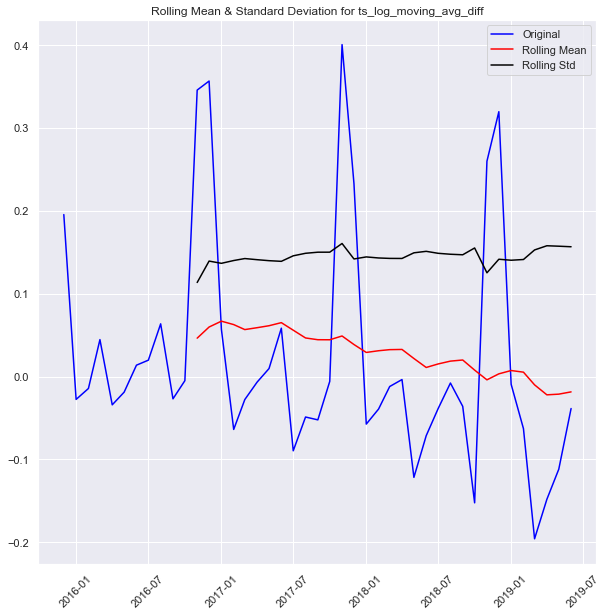

Results of Dickey-Fuller Test:
Test Statistic                 -0.335982
p-value                         0.920251
# Lags Used                    10.000000
Number of Observations Used    32.000000
Critical Value (1%)            -3.653520
Critical Value (5%)            -2.957219
Critical Value (10%)           -2.617588
dtype: float64


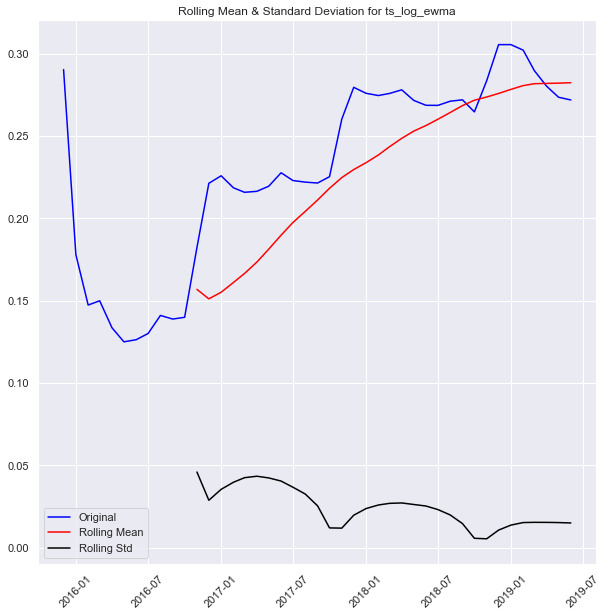

Results of Dickey-Fuller Test:
Test Statistic                 -3.252191
p-value                         0.017156
# Lags Used                    10.000000
Number of Observations Used    32.000000
Critical Value (1%)            -3.653520
Critical Value (5%)            -2.957219
Critical Value (10%)           -2.617588
dtype: float64


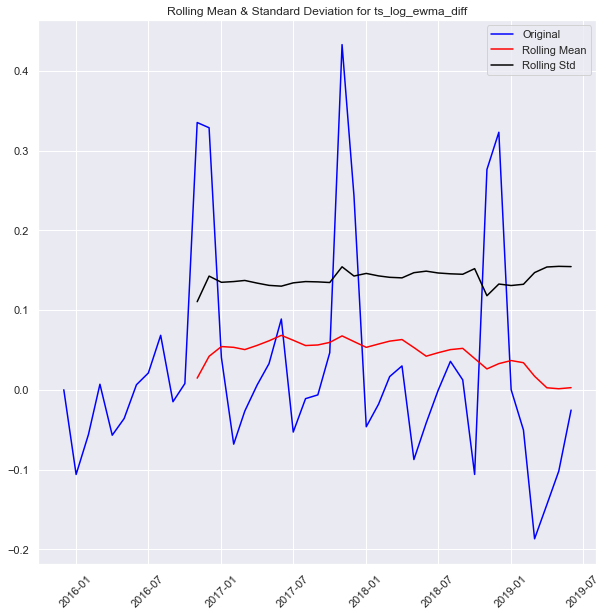

Results of Dickey-Fuller Test:
Test Statistic                 -1.830731
p-value                         0.365315
# Lags Used                    10.000000
Number of Observations Used    32.000000
Critical Value (1%)            -3.653520
Critical Value (5%)            -2.957219
Critical Value (10%)           -2.617588
dtype: float64


In [94]:
# Transformation - log ts
df_sales['ts_log'] = np.log(df_sales['ts'])


df_sales['ts_diff'] = df_sales['ts'] - df_sales['ts'].shift(1)

# Transformation - 7-day moving averages of log ts
df_sales['ts_log_moving_avg'] = df_sales['ts_log'].rolling(window = 12,
                                                           center = False).mean()

# Transformation - 7-day moving average ts
df_sales['ts_moving_avg'] = df_sales['ts'].rolling(window = 12,
                                                   center = False).mean()

# Transformation - Difference between logged ts and first-order difference logged ts
df_sales['ts_log_diff'] = df_sales['ts_log'] - df_sales['ts_log'].shift()
#df['ts_log_diff'] = df['ts_log'].diff()

# Transformation - Difference between ts and moving average ts
df_sales['ts_moving_avg_diff'] = df_sales['ts'] - df_sales['ts_moving_avg']

# Transformation - Difference between logged ts and logged moving average ts
df_sales['ts_log_moving_avg_diff'] = df_sales['ts_log'] - df_sales['ts_log_moving_avg']

# Transformation - Difference between logged ts and logged moving average ts
df_transform = df_sales.dropna()

# Transformation - Logged exponentially weighted moving averages (EWMA) ts
df_transform['ts_log_ewma'] = df_transform['ts_log'].ewm(halflife = 12,
                                                                         ignore_na = False,
                                                                         min_periods = 0,
                                                                         adjust = True).mean()

# Transformation - Difference between logged ts and logged EWMA ts
df_transform['ts_log_ewma_diff'] = df_transform['ts_log'] - df_transform['ts_log_ewma']

# Display data
display(df_transform.head())

# Plot data
plot_transformed_data(df = df_sales, 
                      ts = 'ts', 
                      ts_transform = 'ts_diff')

# Plot data
plot_transformed_data(df = df_sales, 
                      ts = 'ts', 
                      ts_transform = 'ts_log')
# Plot data
plot_transformed_data(df = df_sales, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_moving_avg')

# Plot data
plot_transformed_data(df = df_transform, 
                      ts = 'ts', 
                      ts_transform = 'ts_moving_avg')

# Plot data
plot_transformed_data(df = df_transform, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_diff')

# Plot data
plot_transformed_data(df = df_transform, 
                      ts = 'ts', 
                      ts_transform = 'ts_moving_avg_diff')

# Plot data
plot_transformed_data(df = df_transform, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_moving_avg_diff')

# Plot data
plot_transformed_data(df = df_transform, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_ewma')

# Plot data
plot_transformed_data(df = df_transform, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_ewma_diff')

# Perform stationarity test
test_stationarity(df = df_transform, 
                  ts = 'ts_diff')

# Perform stationarity test
test_stationarity(df = df_transform, 
                  ts = 'ts_log')

# Perform stationarity test
test_stationarity(df = df_transform, 
                  ts = 'ts_moving_avg')

# Perform stationarity test
test_stationarity(df = df_transform, 
                  ts = 'ts_log_moving_avg')

# Perform stationarity test
test_stationarity(df = df_transform,
                  ts = 'ts_log_diff')

# Perform stationarity test
test_stationarity(df = df_transform,
                  ts = 'ts_moving_avg_diff')

# Perform stationarity test
test_stationarity(df = df_transform,
                  ts = 'ts_log_moving_avg_diff')

# Perform stationarity test
test_stationarity(df = df_transform, 
                  ts = 'ts_log_ewma')

# Perform stationarity test
test_stationarity(df = df_transform,
                  ts = 'ts_log_ewma_diff')

# arima

import df sales again

In [95]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(df_sales) #Finds the max value in training data

scaled_df=scaler.transform(df_sales)

df_sales['scaled']=scaled_df[:]+1
df_sales=df_sales.drop(columns=['Sales'])

# Rename columns
df_sales = df_sales.rename(columns = {'scaled': 'ts'})

# look at data
display(df_sales.head())

# look a shape of data
display(df_sales.shape)

# display descriptive statistics
display(df_sales.describe(percentiles=[0.25,0.5,0.75,0.85,0.95,0.99]))

from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = auto_arima(df_sales.ts,
                      m=12,              # frequency of series
                      seasonal=True,   # No Seasonality
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True)

print(model.summary())

ValueError: Wrong number of items passed 10, placement implies 1

## Forecast using Holt Winter Method (Additive Model and Multiplicative Model)

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing


In [ ]:
len(df_sales)-12

 RMSE Error: 0.2326801063


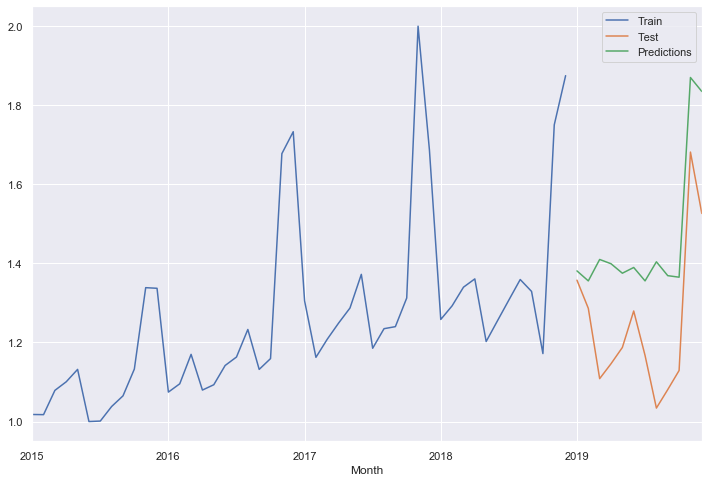

In [60]:
train=df_sales.ts.iloc[:48]
test=df_sales.ts.iloc[48:]
fitted_model=ExponentialSmoothing(train,trend='add',seasonal='add', seasonal_periods=12,damped=True).fit()
test_predictions=fitted_model.forecast(12)
train.plot(legend=True, label='Train', figsize=(12,8))
test.plot(legend=True, label='Test')
test_predictions.plot(legend=True, label='Predictions')
from statsmodels.tools.eval_measures import rmse

error = rmse(test, test_predictions)
print(f' RMSE Error: {error:11.10}')

 RMSE Error: 0.1575742803


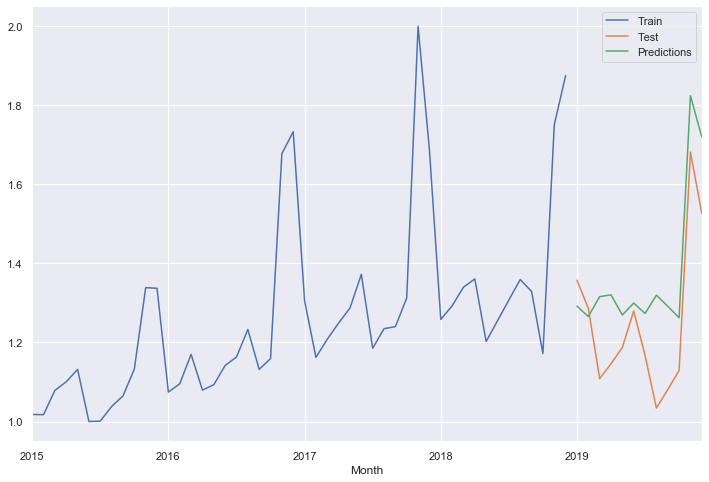

In [34]:
train=df_sales.ts.iloc[:48]
test=df_sales.ts.iloc[48:]
fitted_model=ExponentialSmoothing(train,trend='mul',seasonal='mul', seasonal_periods=12,damped=True).fit()
test_predictions=fitted_model.forecast(12)
train.plot(legend=True, label='Train', figsize=(12,8))
test.plot(legend=True, label='Test')
test_predictions.plot(legend=True, label='Predictions')
from statsmodels.tools.eval_measures import rmse

error = rmse(test, test_predictions)
print(f' RMSE Error: {error:11.10}')